# UDA Midterm Spring 2018 B4

Congratulations! You have been tasked with finding out how news headlines change across months in year 2015!

## 1. Read the data [10 points]

Begin by reading in the headlines from the file `headlines.csv` (which should be in the same folder as this Jupyter notebook).

The first line of the data contains the column headers `publish_date` and `headline_text`. Each line that follows contains the publish date in `YYYYMMDD` format and the headline, separated by a comma. The first few lines of the data look like this:
```
publish_date,headline_text
20050101,10 killed in kashmir new year party called off
20050101,aftershocks continue to rattle aceh
20050101,aid for some aceh survivors weeks away
20050101,aid pours in to indonesia
20050101,american gordon makes dakar rally history
20050101,ancic llodra out of hardcourt champs
20050101,archives reveal act education boost
20050101,archives reveal qld concerns over colour tv
20050101,army choppers to aid relief efforts
```

Tasks:

   1. Read the headlines into a list of strings named `headlines`.
   2. Read the publish dates into a list of strings named `publish_dates` (for now we just leave these as strings).

Hints:

   * Make sure you ignore the header line.

In [1]:
headlines = []
publish_dates = []

################################################################################
# YOUR CODE GOES HERE
with open("headlines.csv", "r") as f:
    f.readline()  # skip header
    for line in f:
        publish_date, headline = line.split(",")
        publish_dates.append(publish_date)
        headlines.append(headline)
################################################################################

In [2]:
print(len(headlines)) # should be 73124
print(len(publish_dates)) # should be 73124

73124
73124


## 2. Preprocess the data [30 points]

Using the `headlines` and `publish_dates` lists created above, perform the following in order:

   1. [15 points] Delete duplicate headlines and their corresponding publish dates (make sure to maintain the association between each headline and publish date). In particular, if a headline appears more than once, only keep the first instance of it being seen in the list `headlines`.
   2. [15 points] Delete stopwords (as specified by spacy's stopwords) from each headline. (We've provided code that imports this stopwords list.)

In [3]:
deduplicated_headlines = []
deduplicated_publish_dates = []

################################################################################
# YOUR CODE GOES HERE
seen = set([])
for idx, headline in enumerate(headlines):
    if not headline in seen:
        deduplicated_headlines.append(headline)
        deduplicated_publish_dates.append(publish_dates[idx])
        seen.add(headline)
################################################################################

In [4]:
print(len(deduplicated_headlines)) # should be 72915
print(len(deduplicated_publish_dates)) # should be 72915

72915
72915


In [5]:
from spacy.lang.en.stop_words import STOP_WORDS

processed_headlines = []

################################################################################
# YOUR CODE GOES HERE
for idx in range(len(deduplicated_headlines)):
    headline = deduplicated_headlines[idx]
    parsed_headline = " ".join([word for word in headline.split() if word not in STOP_WORDS])
    processed_headlines.append(parsed_headline)
################################################################################

As a last step of preprocessing, we represent each headline as a feature vector, very similar to building a histogram. We have provided this code for you. The code uses scikit-learn's `TfidfVectorizer` class, which, similar to `CountVectorizer` in the LDA demo, represents each document as a feature vector (for this exam, each document corresponds to a headline). The resulting variable `X` is a 2-D numpy array, and has rows corresponding to headlines, and columns corresponding to different words. However, the main difference from `CountVectorizer` is that each feature vector value is not just the raw count of how many times a word appeared. Instead, it's the raw count multiplied by a weighting factor (so that "unimportant" words get downweighted more). For the purposes of this exam, you do *not* have to worry about how this weighting works. Just treat `X` as a 2D numpy array where rows are feature vectors.

In [6]:
# *** DO NOT MODIFY CODE IN THIS CELL ***
# If your code above works correctly, then running this cell should output (72915, 5460).
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10, max_df=0.75)
X = vectorizer.fit_transform(processed_headlines)  # This is stored as a sparse array, so as to save memory
                                                   # (very similar to CountVectorizer in the LDA demo!)

print(X.shape) # should be (72915, 5460)

(72915, 5460)


## 3. Cluster the headlines with k-means [20 points]

a. [10 points] In this problem, we use a variant of k-means called mini-batch k-means, which is similar to regular k-Means clustering, but performs faster. Just like with regular k-means, after creating an instance of the `MiniBatchKMeans` class (suppose we call this instance `kmeans`), you use `kmeans.fit` to run mini-batch k-means on the data you would like to cluster. You can then get cluster assignments of the data points using `kmeans.labels_`, and you can get the cluster centers by using `kmeans.cluster_centers_`.

The goal of this problem is to figure out what the value of `k` is according to the so-called ["silhouette score"](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) (note: you don't need to know the details of what this score is computing!--for the purposes of this exam, you just need to know that a higher silhouette score is better).

In particular, for each k=10,20,30,...,100: cluster all the headlines (in full-dimensionality, so don't reduce dimensions!) into k clusters, and compute the silhouette score for this choice of k.

This should take less than 2 minutes to run (for all `k`) and consumes < 2.5GB of RAM.

In [7]:
%%time
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

best_k = None
best_cluster_centers = None
best_labels = None
best_score = -1
for k in range(10, 110, 10):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=95865, verbose=0)
    
    ############################################################################
    # YOUR CODE HERE (cluster data using the kmeans object created above)
    kmeans.fit(X)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    ############################################################################
    
    ############################################################################
    # YOUR CODE HERE (compute silhouette score with default options, except use `sample_size=10000`)
    score = silhouette_score(X, labels, sample_size=10000)
    ############################################################################
    
    if score > best_score:
        ########################################################################
        # YOUR CODE HERE
        best_score = score
        best_k = k
        best_cluster_centers = cluster_centers
        best_labels = labels
        ########################################################################

print("Best k = " + str(best_k))

Best k = 10
CPU times: user 31.8 s, sys: 8.22 s, total: 40.1 s
Wall time: 41.9 s


b. [10 points] For the best choice of k (among 10,20,...,100 that has the highest silhouette score), print 5 *unprocessed* headlines that are closest to each cluster center using cosine distance. There are multiple ways to do this. For example, you could use [pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) (faster). Alternatively you could use [cosine](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.cosine.html).

Example output:
```
Cluster 0
	council under fire over water plan
	council work changes plan under fire
	man to face court over northam death
	feedlot plan divides council
	council urged to rethink water plan support
Cluster 1
	landcare calls for award nominations
	magical nanny leads olivier award nominations
	nominations sought for regional achiever award
	scottish rockers top award nominations
	chelsea players top award nominations
```

In [8]:
# you could use either `pairwise_distances` or `cosine` (no need to use both)
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cosine
import numpy as np

################################################################################
# YOUR CODE GOES HERE
pdists = pairwise_distances(best_cluster_centers, X, metric="cosine")
nearest_headlines_idx = np.argsort(pdists, axis=1)[:,:5]
for cluster_idx in range(best_k):
    headlines_idx = nearest_headlines_idx[cluster_idx,:]
    print("Cluster " + str(cluster_idx))
    for idx in headlines_idx:
        print("\t" + deduplicated_headlines[idx].strip())
################################################################################

Cluster 0
	council under fire over water plan
	council work changes plan under fire
	man to face court over northam death
	feedlot plan divides council
	council urged to rethink water plan support
Cluster 1
	landcare calls for award nominations
	magical nanny leads olivier award nominations
	nominations sought for regional achiever award
	scottish rockers top award nominations
	chelsea players top award nominations
Cluster 2
	police move to new headquarters
	police search for solvent supplier
	police urged to keep emotions diary
	police investigate substation tampering
	police searching for missing man
Cluster 3
	policeman denies crime scene cover up
	no spent cartridges at falconio crime scene court
	workchoices brochures trashed for fairer cover
	abdul on probation after fleeing crash scene
	hearing told public may see crime scene clean as
Cluster 4
	export discrepancies worry cattle producers
	producers urged to start planning for hajj export
	islamic festivals may herald end to cat

## 4. Plot the number of headlines in each cluster over time [40 points]

Construct a matrix C, where C[i][j] is the number of headlines assigned to cluster j that were published during month i.

To help you out, we first provide you the following code that actually determines, for every date in your deduplicated publish date list what its corresponding month is, as an integer:

In [9]:
# *** DO NOT MODIFY CODE IN THIS CELL ***
# As it turns out, Python has a convenient object for dealing with dates.
from datetime import datetime
datetime_objects = [datetime.strptime(str(date), '%Y%m%d') for date in deduplicated_publish_dates]

# now compute out all the months for each deduplicated date!
months = np.array([datetime_object.month for datetime_object in datetime_objects])
print(len(months))  # should be 72915
print(months)  # should go from 1's to 12's (corresponding to headlines published in January through December)

72915
[ 1  1  1 ..., 12 12 12]


a. [25 points] Construct `C`:

   1. The variable `best_labels` contains the cluster index that each headline is assigned to.
   2. The variable `months` contains the month that each headline was published in.
   3. For each month `i = 1, ..., 12` and cluster index `j = 0, ..., best_k-1`:
      - Count the number of headlines assigned to cluster `j` that were published in month `i`.
      - Store this count in `C[i-1][j]`.

In [10]:
C = np.zeros((12, best_k), dtype=np.int)
for month in range(1, 13):
    headlines_in_month_mask = (months == month)
    labels_select = best_labels[headlines_in_month_mask]
    label_counts = np.bincount(labels_select, minlength=best_k)
    C[month-1,:] = label_counts

b. [10 points] Given `C`, for each cluster index `0, ..., best_k-1`:

   1. Line-plot the number of headlines assigned to that cluster in each month.
   2. Ignore cluster indices for which the maximum number of headlines in any month is < 100 (no line-plots for these clusters).
   3. There should be one plot for each unignored cluster index. An example plot is below:

<img src="example.png">

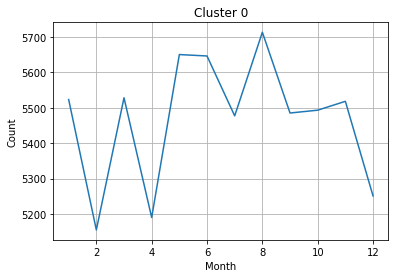

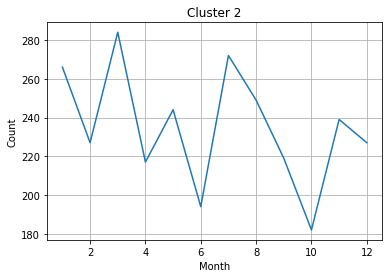

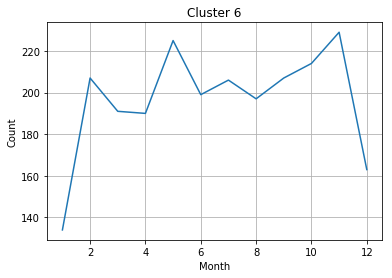

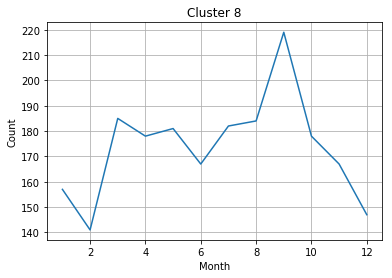

In [11]:
import matplotlib.pyplot as plt
for i in range(best_k):
    month_counts = C[:,i]
    if max(month_counts) < 100:
        continue
    plt.figure()
    plt.plot(range(1, 13, 1), month_counts)
    plt.title("Cluster " + str(i))
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.grid()
    plt.show()

c. [5 points] Using the headlines corresponding to the cluster centers that you printed in Q3, interpret each of the line plots created above. There is no right answer here, do your best. Example interpretations are:

   * Cluster 0: Road accidents peaked in November.
   * Cluster 1: Government subsidies were handed out every alternate month.
   * Cluster 2: Cannot be interpreted.